 # ML Model
 
 This notebook is to create and train a tensorflow model to recognize pictures of the sky as different weather conditions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob

In [3]:
data_path = '../Resources/dataset2'

data_dir = pathlib.Path(data_path)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


766


This is the first image of clouds to signify cludy skies

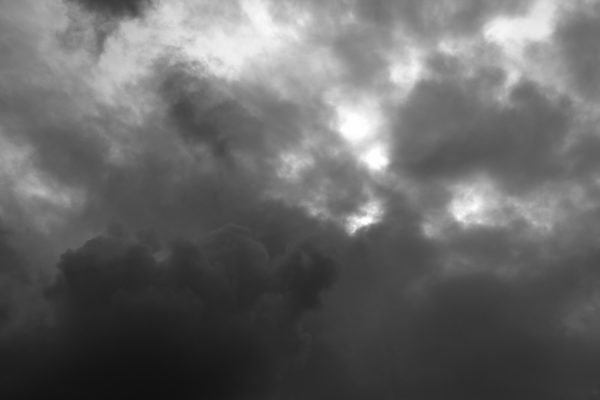

In [4]:
clouds = list(data_dir.glob('clouds/*'))
PIL.Image.open(str(clouds[0]))

We break it up into batch size 32 with 240x240px pictures to try to hit a balance between high resolution enough to be accurate but small enough to quickly train the model

In [5]:
batch_size = 32
img_height = 240
img_width = 240

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 768 files belonging to 3 classes.
Using 615 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 768 files belonging to 3 classes.
Using 153 files for validation.


these are the 3 different classifications of weather that this dataset will provide training for

In [7]:
class_names = train_ds.class_names
print(class_names)

['clouds', 'rain', 'sunshine']


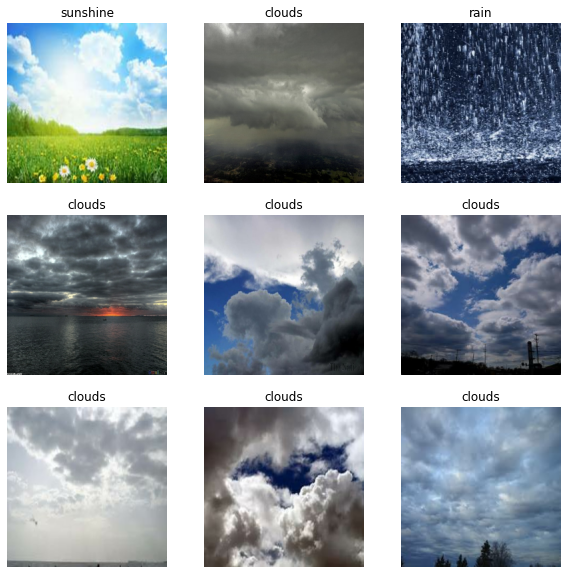

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

double checking the batch dimensions

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 240, 3)
(32,)


this is precaching pictures to speed up the model

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

we rescale the color info to be 0-1 in place of 0-255 to allow for better training

In [11]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## WHat does this do?

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [15]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
20/20 [==============================] - 13s 604ms/step - loss: 0.8059 - accuracy: 0.6374 - val_loss: 0.7351 - val_accuracy: 0.6993
Epoch 2/50
20/20 [==============================] - 12s 621ms/step - loss: 0.4341 - accuracy: 0.8390 - val_loss: 0.4676 - val_accuracy: 0.8301
Epoch 3/50
20/20 [==============================] - 12s 617ms/step - loss: 0.4255 - accuracy: 0.8341 - val_loss: 0.5036 - val_accuracy: 0.8366
Epoch 4/50
20/20 [==============================] - 12s 615ms/step - loss: 0.2604 - accuracy: 0.8959 - val_loss: 0.6775 - val_accuracy: 0.7778
Epoch 5/50
20/20 [==============================] - 12s 622ms/step - loss: 0.2804 - accuracy: 0.8927 - val_loss: 0.6085 - val_accuracy: 0.7582
Epoch 6/50
20/20 [==============================] - 11s 552ms/step - loss: 0.1820 - accuracy: 0.9382 - val_loss: 0.5430 - val_accuracy: 0.8497
Epoch 7/50
20/20 [==============================] - 11s 533ms/step - loss: 0.0987 - accuracy: 0.9740 - val_loss: 0.7053 - val_accuracy: 0.8627

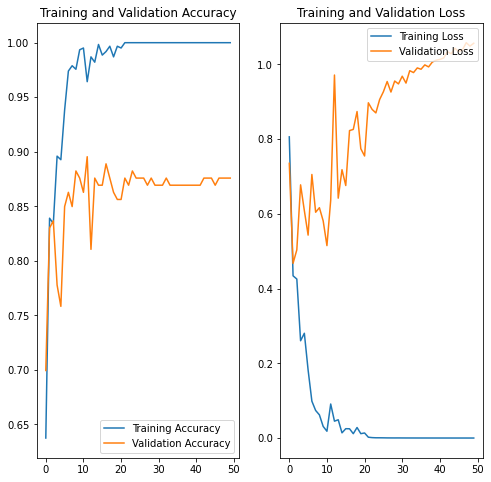

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:


saved_model = "Weather_model.h5"
# Create a callback that saves the model's weights
Weather_model_trained.save(saved_model)

In [3]:


saved_model = "Weather_model.h5"
Weather_model_trained = tf.keras.models.load_model(saved_model)
Weather_model_trained.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 64)       